# **Canny Edge Detector implementation**

In [1]:
import os
from os.path import join
import cmath
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.signal import convolve2d,gaussian

In [2]:
outputgray = join(''.join(['output/gray_scale/']));           # Directory to save the images in for the report
outputcan = join(''.join(['output/Canny/']));
outputgrad = join(''.join(['output/Orientation/']));
outputmag = join(''.join(['output/gradiient_magnitude/']));
outputD = join(''.join(['output/D*/']));
outputENMS = join(''.join(['output/Edge_NMS/']));
outputCNMS = join(''.join(['output/Corner_NMS/']));
outputC = join(''.join(['output/Corner/']));
outputfx = join(''.join(['output/Fy/']));
outputfy = join(''.join(['output/Fx/']));

Result=[outputgray,outputcan,outputgrad,outputmag,outputD,outputENMS,outputCNMS,outputfx,outputfy,outputC]
for outputPath in Result:
  if not(os.path.exists(outputPath)):
    os.makedirs(outputPath)

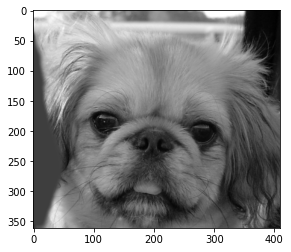

In [3]:
imgname='dog.bmp'                       #Name of the image file goes here
img=mpimg.imread(imgname)
img=np.asarray(img,dtype='float64')
pixel=np.zeros((img.shape[0],img.shape[1]),dtype='float')
pixel=0.2126*img[:,:,0]+0.7152*img[:,:,1]+0.0722*img[:,:,2]           #Converting RGB to gray scale image
plt.imshow(pixel,cmap='gray')
mpimg.imsave(''.join([outputgray,imgname]),pixel,cmap='gray')

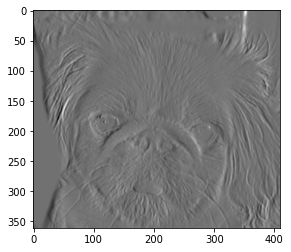

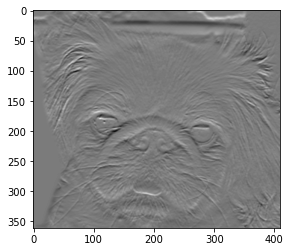

'Fx and Fy are the image gradient components after smooting the image'

In [4]:
fx=np.array([np.array([-1,1])])       #x-comp gradient filter
fy=np.transpose(fx)        #y-comp gradient filter
window=gaussian(21,std=1)         
window=np.outer(window,window)            #2D gaussian kernel with sigma =1
fgx=convolve2d(window,fx,boundary='symm',mode='same')             #x-derivative of gaussian
fgy=convolve2d(window,fy,boundary='symm',mode='same')             #y-derivative of gaussian
Fx=convolve2d(pixel,fgx,boundary='symm',mode='same')             #covolution with xderivative of gaussian
Fy=convolve2d(pixel,fgy,boundary='symm',mode='same')             #covolution with yderivative of gaussian
plt.figure(1)
plt.imshow(Fx,cmap='gray')
mpimg.imsave(''.join([outputfx,imgname]),Fx,cmap='gray')
plt.figure(2)
plt.imshow(Fy,cmap='gray')
mpimg.imsave(''.join([outputfy,imgname]),Fy,cmap='gray')
plt.show()
'''Fx and Fy are the image gradient components after smooting the image'''

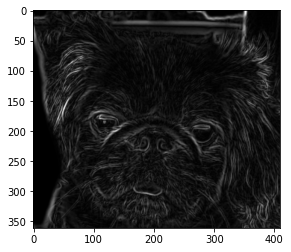

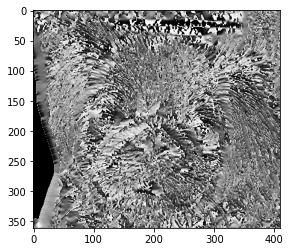

In [5]:
D=np.divide(Fy,Fx)                      
D=np.arctan(D)                          #Orientation of the gradient at each pixel
F=Fx+Fy*1j
F=np.absolute(F)                        #gradient magnitude at each pixel
plt.figure(3)
plt.imshow(F,cmap='gray')
plt.figure(4)
plt.imshow(D,cmap='gray')
plt.show()
mpimg.imsave(''.join([outputgrad,imgname]),D,cmap='gray')
mpimg.imsave(''.join([outputmag,imgname]),F,cmap='gray')

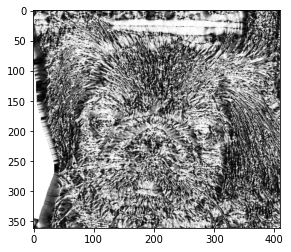

In [6]:
plt.imshow(np.absolute(D),cmap='gray')

In [7]:
D_star=np.array([0,np.pi/4,np.pi/2,3*np.pi/4])                #D* values mentioned in the assignment
D=np.absolute(D)
for i in range(len(D)):
  for j in range(len(D[0])):
    orientation=0
    diff=10000                        #a random high difference value initialized b/w orientation and D* that can never be attained normally
    for o in D_star:
      if(abs(D[i][j]-o)<diff):
        orientation=o
        diff=abs(D[i][j]-o)
    D[i][j]=orientation                 # set the orientation of the pixel to one of the D* values (which it is closest)

In [8]:
mpimg.imsave(''.join([outputD,imgname]),D,cmap='gray')

In [9]:
I=np.zeros_like(F)                    # Matrix that will have edges of length 1 pixel(Non maximal suppresion)
for i in range(len(D)):
  for j in range(len(D[0])):
    if(D[i][j]==np.pi/4):
      if(i+1<len(D) and j+1 <len(D[0])):
        if(F[i+1][j+1]>F[i][j]):
          continue
      if(i-1>0 and j-1 >0):
        if(F[i-1][j-1]>F[i][j]):
          continue
    elif(D[i][j]==np.pi/2):
      if(i+1<len(D)):
        if(F[i+1][j]>F[i][j]):
          continue
      if(i-1>0):
        if(F[i-1][j]>F[i][j]):
          continue
    elif(D[i][j]==0):
      if(j+1<len(D[0])):
        if(F[i][j+1]>F[i][j]):
          continue
      if(j-1>0):
        if(F[i][j-1]>F[i][j]):
          continue
    else:
      if(i+1<len(D) and j-1 >0):
        if(F[i+1][j-1]>F[i][j]):
          continue
      if(j+1<len(D[0]) and i-1 >0):
        if(F[i-1][j+1]>F[i][j]):
          continue
    I[i][j]=F[i][j]

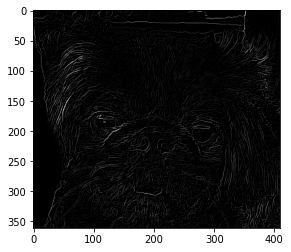

In [10]:
plt.imshow(I,cmap='gray')   #after NMS
mpimg.imsave(''.join([outputENMS,imgname]),I,cmap='gray')

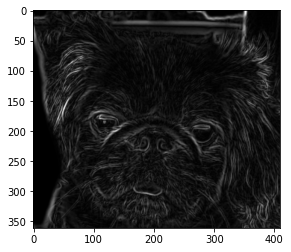

In [11]:
plt.imshow(F,cmap='gray') #Before NMS (For comparison)

In [12]:
T_low=50                     #Low threshold (values recommended for each image)     #dog 50  #bicycle 100   #bird 50    #einstein 50     #plane 20   #toy_image 70
T_high=75                     #High threshold (values recommended for each image)  #dog 75  #bicycle 200   #bird 140   #einstein 140    #plane 145  #toy_image 160
strong=[]                      # List to contain all strong edge pixels
Indicator=np.zeros_like(I)
for i in range(len(I)):
  for j in range(len(I[0])):
    if(I[i][j]>T_high):
      Indicator[i][j]=2           #Strong edge pixels are indicated by 2
      strong.append([i,j])
    elif(I[i][j]>T_low):
      Indicator[i][j]=1           # Weak edge pixels indicated by 1
                                  # Not edge pixels are indicated by 0

In [13]:
from queue import Queue

In [14]:
q=Queue(maxsize=100000)                 #queue to perform DFS search
vis=np.zeros_like(I)                    # array to keep track of which pixels have been visited

for i in range(len(strong)):
  y,x=strong[i]
  if (vis[y][x]==1):
    continue
  q.put([y,x])
  while(q.empty==False):
    y,x=q.get()
    vis[y][x]=1
    if(y+1<len(I)):
        if(vis[y+1][x]==0):
          if(Indicator[y+1][x]!=0):
            Indicator[y+1][x]=2
            q.put([y+1,x])
        if(x+1<len(I[0])):
          if(vis[y+1][x+1]==0):
            if(Indicator[y+1][x+1]!=0):
              Indicator[y+1][x+1]=2
              q.put([y+1,x+1])
        if(x-1>0):
          if(vis[y+1][x-1]==0):
            if(Indicator[y+1][x-1]!=0):
              Indicator[y+1][x-1]=2
              q.put([y+1,x-1])
    if(x+1<len(I[0])):
        if(vis[y][x+1]==0):
          if(Indicator[y][x+1]!=0):
            Indicator[y][x+1]=2
            q.put([y,x+1])    
    if(x-1>0):
        if(vis[y][x-1]==0):
          if(Indicator[y][x-1]!=0):
            Indicator[y][x-1]=2
            q.put([y,x-1])
    if(y-1>0):
        if(vis[y-1][x]==0):
          if(Indicator[y-1][x]!=0):
            Indicator[y-1][x]=2
            q.put([y-1,x])
        if(x+1<len(I[0])):
          if(vis[y-1][x+1]==0):
            if(Indicator[y-1][x+1]!=0):
              Indicator[y-1][x+1]=2
              q.put([y-1,x+1])
        if(x-1>0):
          if(vis[y-1][x-1]==0):
            if(Indicator[y-1][x-1]!=0):
              Indicator[y-1][x-1]=2
              q.put([y-1,x-1])


In [15]:
for i in range(len(I)):
  for j in range(len(I[0])):
    if(Indicator[i][j]==1):                   #weak edge pixels that are not connected to strong edged pixels
      Indicator[i][j]=0                       #labelling those weak edge pixels as no edge pixels

I_copy=np.zeros_like(I)
for i in range(len(I)):
  for j in range(len(I[0])):
    if(Indicator[i][j]==2):
      I_copy[i][j]=255

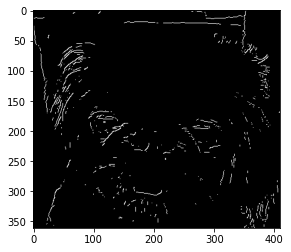

In [16]:
plt.imshow(I_copy,cmap='gray')

In [17]:
mpimg.imsave(''.join([outputcan,imgname]),I_copy,cmap='gray')

#**Harris Corner detector**

In [18]:
m=4
k=0.04
avg=np.power(2*m+1,2)
T=850               #Threshold value when computing eigen values(value recommended)-> #dog 850  #bicycle 5000   #bird 2000    #einstein 4000  #plane 1400 toy_image 4000
#T=2000000                          #(Not using this method to compute e)Threshold value when computing  e = Determinant(C)-k(Trace(C))2 # dog 2000000
L=[]                  #list that will contain the eigen values greater than the threshold
Lp=[]                 #list that will contain the corresponding pixels
C=np.zeros((2,2))
for i in range(m,len(Fx)-m):
  for j in range(m,len(Fx[0])-m):
    dotFx2=0
    dotFy2=0
    fxfy=0
    for u in range(-m,m+1):
      for v in range(-m,m+1):
        dotFx2+=np.power(Fx[i+u][j+v],2)          
        dotFy2+=np.power(Fy[i+u][j+v],2)   
        fxfy+=Fx[i+u][j+v]*Fy[i+u][j+v]       
    C[0][0]=dotFx2/avg
    C[0][1]=fxfy/avg
    C[1][0]=fxfy/avg
    C[1][1]=dotFy2/avg
    #e=(C[0][0]*C[1][1])-(C[0][1]*C[1][0])-k*np.power((C[0][0]+C[1][1]),2)
    e,v=np.linalg.eig(C)
    e=np.min(e)
    if(e>T):
      L.append(e)
      Lp.append([i,j])
    

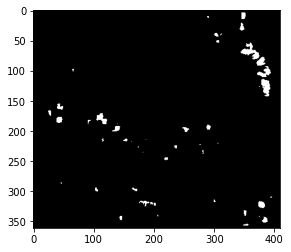

In [19]:
cor=np.zeros_like(Fx)
arr=np.array(L)
for i in range(len(arr)):
  y,x=Lp[i]
  cor[y][x]=255
plt.imshow(cor,cmap='gray')
mpimg.imsave(''.join([outputC,imgname]),cor,cmap='gray')

In [20]:
z=np.argsort(np.multiply(L,-1))       #sorting in decreasing order and getting those indices
z=z.tolist()                          

In [21]:
for i in z:                     #Checking if the 8 neighborhood pixels exist in the list and if they do delete them
  y,x=Lp[i]
  if([y+1,x] in Lp):
    if(Lp.index([y+1,x]) in z):
      z.remove(Lp.index([y+1,x]))
  if([y+1,x+1] in Lp):
    if(Lp.index([y+1,x+1]) in z):
      z.remove(Lp.index([y+1,x+1]))
  if([y+1,x-1] in Lp):
    if(Lp.index([y+1,x-1]) in z):
      z.remove(Lp.index([y+1,x-1]))
  if([y,x+1] in Lp):
    if(Lp.index([y,x+1]) in z):
      z.remove(Lp.index([y,x+1]))
  if([y,x-1] in Lp):
    if(Lp.index([y,x-1]) in z):
      z.remove(Lp.index([y,x-1]))
  if([y-1,x] in Lp):
    if(Lp.index([y-1,x]) in z):
      z.remove(Lp.index([y-1,x]))
  if([y-1,x-1] in Lp):
    if(Lp.index([y-1,x-1]) in z):
      z.remove(Lp.index([y-1,x-1]))
  if([y-1,x+1] in Lp):
    if(Lp.index([y-1,x+1]) in z):
      z.remove(Lp.index([y-1,x+1]))  

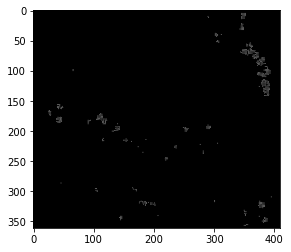

In [22]:
harris_cor=np.zeros_like(F)
for i in z:
  y,x=Lp[i]
  harris_cor[y][x]=255
plt.imshow(harris_cor,cmap='gray')
mpimg.imsave(''.join([outputCNMS,imgname]),harris_cor,cmap='gray')

In [23]:
#import shutil                      #Save the outputs 
#shutil.make_archive('output', 'zip', 'output')